**Greedy Search Decoding**

**Greedy Search Decoding** is a method used by AI language models (like GPT-2, used in AI Dungeon) to generate text. When the model produces text, it doesn’t “know” the entire sentence in advance. Instead, it picks one word (or token) at a time. Greedy search means the model always chooses the word with the highest probability of being correct based on what it’s seen so far.

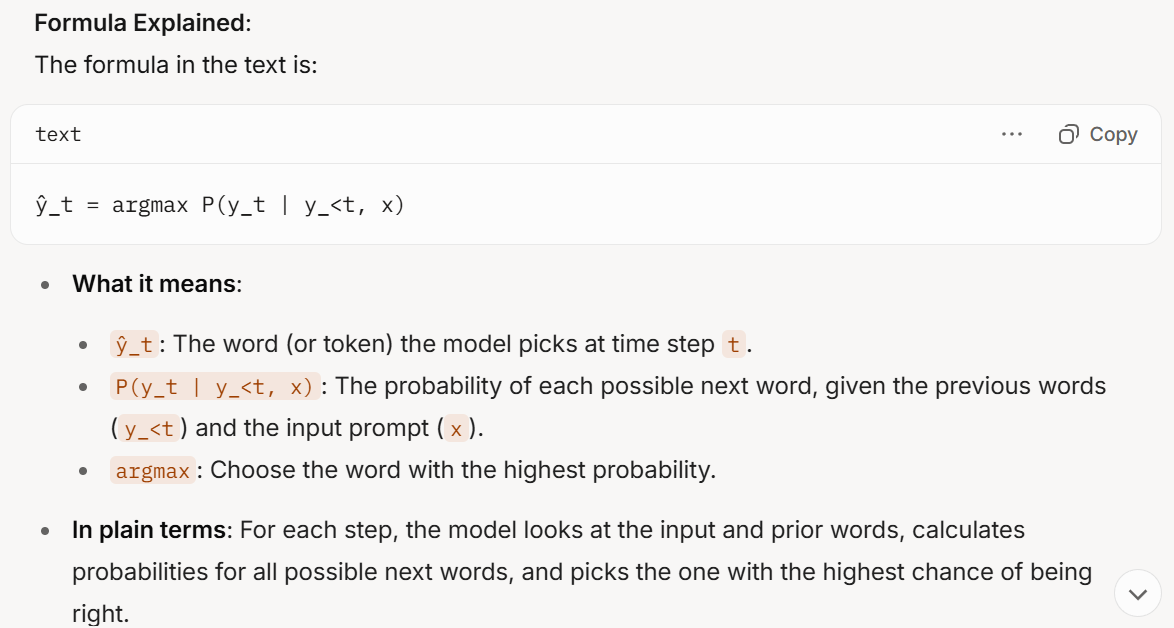

In [ ]:
!pip install transformers --upgrade
# set up a GPT-2 model to generate text using Transformers library(from Hugging Face)
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM # Correct class name to AutoModelForCausalLM

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
model_name='gpt2-xl' #1.5-billion-parameter version of GPT-2 (a large, powerful model)
tokenizer=AutoTokenizer.from_pretrained(model_name) # Downloads the pre-trained tokenizer matched to GPT-2-xl

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model=AutoModelForCausalLM.from_pretrained(model_name).to(device) # Downloads the pre-trained GPT-2-xl model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
input_txt='Transformers are the'
input_ids=tokenizer(input_txt,return_tensors='pt')['input_ids'].to(device)
#return_tensors="pt" part tells the tokenizer to format the output as a PyTorch tensor
#The tokenizer’s output is a dictionary, and ["input_ids"] grabs one specific part: the list of token IDs
#.to(device) moves the token IDs (the tensor) to the chosen device so the model can process it there.
print(input_ids)
iterations=[] #Creates an empty list to store results for each step.
n_steps=12#Plans to generate eight new words
choices_per_step=5 #Will track the top five most likely words at each step
print(input_ids)
print(tokenizer.decode(input_ids[0]))
decode_tokens=tokenizer.convert_ids_to_tokens(input_ids[0])
print(decode_tokens)

tensor([[41762,   364,   389,   262]], device='cuda:0')
tensor([[41762,   364,   389,   262]], device='cuda:0')
Transformers are the
['Transform', 'ers', 'Ġare', 'Ġthe']


In [ ]:
with torch.no_grad(): # Tells PyTorch not to track calculations for training, making the process faster since we’re just generating text.
  for _ in range(n_steps):
    iteration=dict() # Creates a dictionary to store info for this step (current input and top five choices)
    iteration['Input']=tokenizer.decode(input_ids[0])# This line takes the current sequence of token IDs (numbers representing words or parts of words) and converts it back into human-readable text, storing it in a dictionary called iteration under the key "Input"
    outputs=model(input_ids=input_ids) # Feeds the tokens into the model, which outputs logits (scores for all possible next words)
    print(outputs.logits.size())
    next_token_logits=outputs.logits[0,-1,:] # The result, output.logits[0, -1, :], is a 1D tensor of shape [vocab_size] (e.g., [50257]), containing the logits for the next token after the last one in the input.
    next_token_probs=torch.softmax(next_token_logits,dim=-1)
    sorted_ids=torch.argsort(next_token_probs,dim=-1,descending=True)
    # Loop for top five choices:
    for choice_idx in range(choices_per_step):
      token_id=sorted_ids[choice_idx]
      token_prob = next_token_probs[token_id].cpu().numpy() # Gets the probability and converts it to a regular number.
      token_choice = f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
      iteration[f"Choice {choice_idx+1}"] = token_choice
    input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)#adds the highest-probability word (greedy choice) to the input for the next step.
    iterations.append(iteration)#Saves the step’s results (input and top five choices)
print(iterations)
pd.DataFrame(iterations)





torch.Size([1, 4, 50257])
torch.Size([1, 5, 50257])
torch.Size([1, 6, 50257])
torch.Size([1, 7, 50257])
torch.Size([1, 8, 50257])
torch.Size([1, 9, 50257])
torch.Size([1, 10, 50257])
torch.Size([1, 11, 50257])
torch.Size([1, 12, 50257])
torch.Size([1, 13, 50257])
torch.Size([1, 14, 50257])
torch.Size([1, 15, 50257])
[{'Input': 'Transformers are the', 'Choice 1': ' most (8.53%)', 'Choice 2': ' only (4.96%)', 'Choice 3': ' best (4.65%)', 'Choice 4': ' Transformers (4.37%)', 'Choice 5': ' ultimate (2.16%)'}, {'Input': 'Transformers are the most', 'Choice 1': ' popular (16.78%)', 'Choice 2': ' powerful (5.37%)', 'Choice 3': ' common (4.96%)', 'Choice 4': ' famous (3.72%)', 'Choice 5': ' successful (3.20%)'}, {'Input': 'Transformers are the most popular', 'Choice 1': ' toy (10.63%)', 'Choice 2': ' toys (7.23%)', 'Choice 3': ' Transformers (6.60%)', 'Choice 4': ' of (5.46%)', 'Choice 5': ' and (3.76%)'}, {'Input': 'Transformers are the most popular toy', 'Choice 1': ' line (34.38%)', 'Choice

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)
8,Transformers are the most popular toy line in ...,and (32.51%),with (18.66%),but (8.06%),so (5.42%),having (2.19%)
9,Transformers are the most popular toy line in ...,the (11.70%),they (7.48%),it (6.24%),for (3.06%),I (2.97%)


In [ ]:
print(outputs.logits.size())


torch.Size([1, 15, 50257])


In [ ]:
input_txt=['Transformers are the','Sri Lanka is']
tokenizer.pad_token = tokenizer.eos_token

input_ids=tokenizer(input_txt,return_tensors='pt',padding=True)['input_ids'].to(device)
print(input_ids)
output=model.generate(input_ids,max_new_tokens=10,do_sample=False)
print(tokenizer.decode(output[0]))
print(tokenizer.decode(output[1]))
print(output[0],'\n',output[1])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[41762,   364,   389,   262],
        [   50,   380, 28143,   318]], device='cuda:0')
Transformers are the most popular toy line in the world, and the
Sri Lanka is a country of contrasts. It is a country of
tensor([41762,   364,   389,   262,   749,  2968, 13373,  1627,   287,   262,
          995,    11,   290,   262], device='cuda:0') 
 tensor([   50,   380, 28143,   318,   257,  1499,   286, 39469,    13,   632,
          318,   257,  1499,   286], device='cuda:0')


In [ ]:
max_length = 128
input_txt = "In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n"

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
mask=tokenizer(input_txt,return_tensors="pt")["attention_mask"].to(device)

output_greedy = model.generate(input_ids, max_length=max_length,do_sample=False) # Calls the model.generate() function from the Transformers library to generate text.
print(tokenizer.decode(output_greedy[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


The newline character (\n) is also a token in GPT-2’s vocabulary (token ID 198), often appearing naturally in the generated text to separate lines or paragraphs


In [ ]:
print(mask)

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')


###Issues with Greedy Search

**Repetitive Output:** Greedy search tends to produce repetitive sequences, which is “undesirable in a news article.”

**Why Repetition Happens:** Greedy search picks the highest-probability token at each step, which can lead to getting “stuck” in repetitive patterns. It misses potentially better sequences with higher overall probability because it doesn’t look ahead—it only optimizes for the next token.

Greedy search is short-sighted. It doesn’t plan the whole sentence or story—it just picks the best next word based on the current context.

For example, after generating “The researchers were surprised to find that the unicorns were able”, the model might assign high probability to “to” (to continue the sentence) and then repeat similar phrases because they’re locally probable.

Where Greedy Search is Good:

Arithmetic: Ensures correct answers (e.g., “5 + 8 = 13”) by picking the highest-probability token for short, factual outputs.

Simple Factual Completions: Reliable for predictable tasks like “The capital of France is Paris” or basic translations (e.g., “hello” to “bonjour”).

Short, Structured Outputs: Works well for brief, template-like responses where consistency is key and diversity isn’t needed.

### Beam search decoding

Beam search is an alternative decoding method to greedy search for generating text with language models like GPT-2. Instead of picking the single most probable next token at each step (as greedy search does), beam search keeps track of multiple possible sequences (called beams or partial hypotheses) and explores them to find a better overall sequence

In [ ]:
import torch.nn.functional as F #mports PyTorch’s functional module (F), which provides operations like log_softmax and softmax.

def log_probs_from_logits(logits,labels):
  logp=F.log_softmax(logits,dim=-1) #Applies the log_softmax function to the logits tensor along the last dimension (dim=-1, the vocabulary dimension).
                                    #logp is a tensor of the same shape as logits (e.g., [1, 4, 50257]), where each value is the log probability of a token in the vocabulary for each position in the sequence.
  logp_label=torch.gather(logp,2,labels.unsqueeze(2)).squeeze(-1)#Selects the log probabilities for the specific tokens in labels from the logp tensor.
  return logp_label

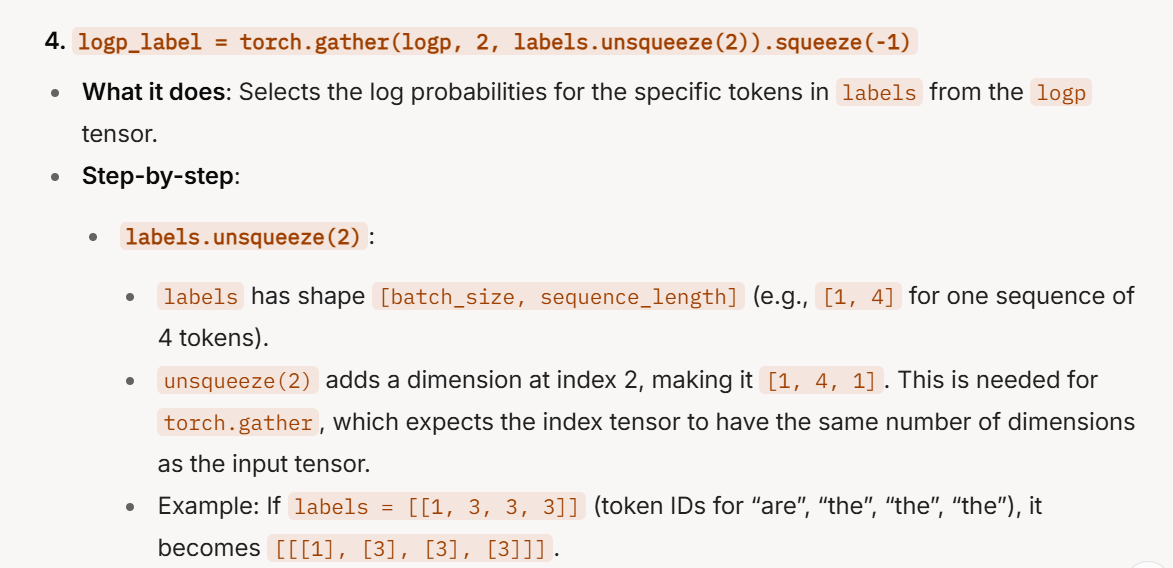

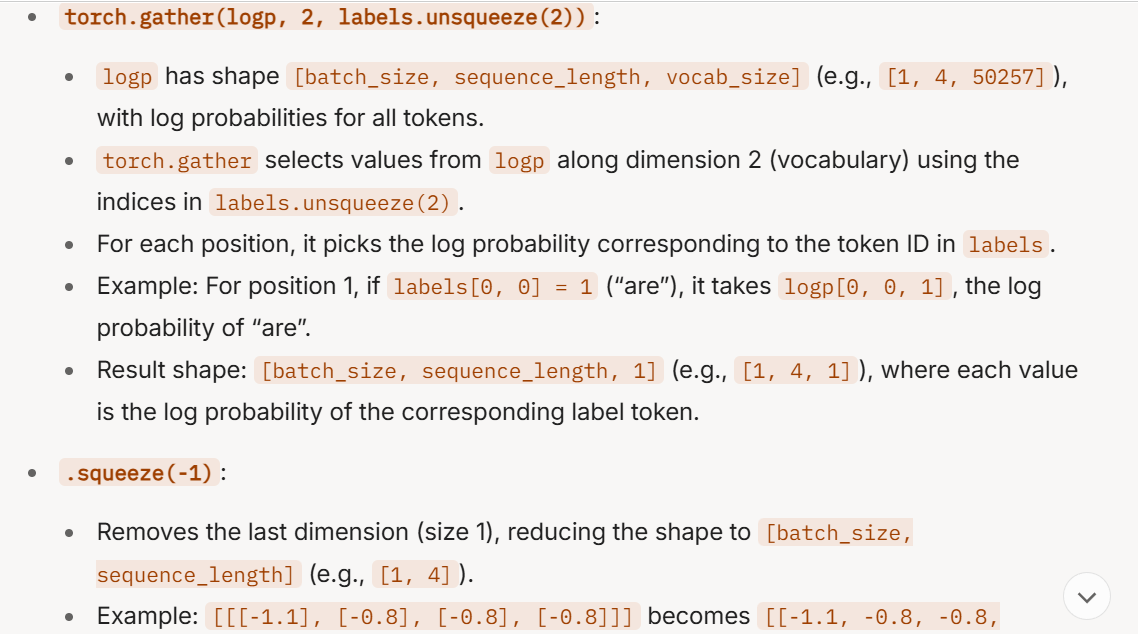



In [ ]:
def sequence_logprob(model, labels, input_len=0):
 with torch.no_grad():
  output = model(labels)
  log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
  seq_log_prob = torch.sum(log_probs[:, input_len:])
 return seq_log_prob.cpu().numpy() #Output: A NumPy array containing the total log probability of the sequence (excluding the first input_len tokens)

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

log-prob: -88.66


In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
 do_sample=False) #Uses the model.generate() method from the Transformers library to generate text with beam search.
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
# Runs model(output_beam) to get logits for the entire sequence (shape [1, 128, 50257]).
#Uses log_probs_from_logits to compute log probabilities of the tokens in output_beam, aligning logits (predicting tokent+1) with labels (token t+1).
#Sums the log probabilities of the generated tokens (excluding the first input_len tokens) to get the total log probability.
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English

log-prob: -56.45


Here, we can see that beam search also
 suffers from repetitive text. One way to address this is to impose an n-gram penalty
 with the no_repeat_ngram_size parameter that tracks which n-grams have been seen
 and sets the next token probability to zero if it would produce a previously seen
 n-gram:

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)

logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the area when they came across the herd. They were surprised to find that they were able to converse with the animals in English, even though they had never seen a unicorn in person before. The researchers were

log-prob: -94.35


This parameter bans any 2-gram (sequence of 2 tokens) from repeating in the generated text or from the prompt. If a 2-gram (e.g., “the researchers”) appears, its probability is set to 0 for future tokens, forcing the model to choose a different continuation

### Sampling Methods
** Why Sampling?**

* Beam search with no_repeat_ngram_size (as in our last code: no_repeat_ngram_size=2, log-prob -93.12) avoids repetition but can still favor high-probability tokens, limiting diversity. The n-gram penalty forces the model to choose less probable tokens to avoid repeats, lowering the log probability (e.g.: -93.12 vs. -54.40 without the penalty).

* Sampling introduces randomness, allowing the model to pick tokens probabilistically rather than always choosing the most likely ones, which can lead to more varied outputs at the cost of potentially lower log probabilities.

In [ ]:
output_temp=model.generate(input_ids,#negative_prompt_attention_mask=mask,max_length=max_length
                           do_sample=True,temperature=2.0,top_k=0)
print(tokenizer.decode(output_temp[0]))
#top_k=0: Disables top-k sampling, meaning the model samples from the entire vocabulary (all 50,257 tokens for GPT-2), not just the top k tokens.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

 speedup souvenirkauriskrazyinniste summarizeDelete crushed denyingfinishedgivingstock expansion obedienceHigh creator


We can clearly see that a high temperature has produced mostly gibberish; by accen
tuating the rare tokens, we’ve caused the model to create strange grammar and quite a
 few made-up words!


In [ ]:
#cool down the temperature
output_temp=model.generate(input_ids,do_sample=True,temperature=0.5,top_k=0)
print(tokenizer.decode(output_temp[0]))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of Michigan, studied the herd of about 50 animals, which were


This is significantly more coherent, and even includes a quote from yet another uni
versity being credited with the discovery! The main lesson we can draw from temper
ature is that it allows us to control the quality of the samples, but there’s always a
 trade-off between coherence (low temperature) and diversity (high temperature) that
 one has to tune to the use case at hand.

 Another way to adjust the trade-off between coherence and diversity is to truncate
 the distribution of the vocabulary. This allows us to adjust the diversity freely with
 the temperature, but in a more limited range that excludes words that would be too
 strange in the context (i.e., low-probability words). There are two main ways to do
 this: top-k and nucleus (or top-p) sampling.

### Top-k and Nucleus Sampling

**Top-k**
* It sorts the tokens by probability and selects the top
k tokens with the highest probabilities.
* The probabilities of these top
k tokens are renormalized (so they sum to 1), and the model samples a token randomly from this subset, ignoring all other tokens.
* **Purpose :**Restricts sampling to the most likely tokens, balancing diversity (via randomness) and quality (by avoiding very low-probability tokens).

**Top-p (Nucleus) Sampling**
* Instead of a fixed number of tokens (
k), top-p sampling selects the smallest set of tokens whose cumulative probability exceeds a threshold
p.

* It sorts tokens by probability, accumulates their probabilities until the sum exceeds
p, and samples only from this “nucleus” of tokens, ignoring the rest.

* **Purpose :** Adaptive: The number of tokens sampled varies based on the distribution, allowing more flexibility than top-k.

In [ ]:
output_topk = model.generate(input_ids, max_length=250, do_sample=True, top_k=50)

print(tokenizer.decode(output_topk[0]))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The team's report, published in The Proceedings of the National Academy of Sciences (PNAS), studied the unicorns' vocalizations using the ultrasonic vocalizations of five young female Andean elephants. The elephants' behavior and vocalizations are used to create a sound wave that is transmitted to computers which analyze the patterns and produce computer-generated synthetic forms, which then vibrate in response to the voice. This process creates synthetic sounds, which were then synthesized into human speech using a speech recognition system.

"The study highlights both the beauty and potential hazards of the Andes Mountains," said Dr. Jennifer L. Renship, Principal Investigator of the study and an assistant professor of psychology at Rutgers University in 

 We can also apply beam search when we use sampling. Instead of
 selecting the next batch of candidate tokens greedily, we can sample
 them and build up the beams in the same way.

 You can even combine the two
 sampling approaches to get the best of both worlds. Setting top_k=50 and top_p=0.9
 corresponds to the rule of choosing tokens with a probability mass of 90%, from a
 pool of at most 50 tokens.

In [ ]:
print(output_topk)
print(tokenizer.decode([3594,13,628,198,464]))

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198,   464,  1074,   338,
           989,    11,  3199,   287,   383, 30641,   286,   262,  2351,  8581,
           286, 13473,   357, 13137,  1921,   828,  9713,   262, 28000, 19942,
             6, 12435,  4582,  1262,   262, 23212, 30189, 12435,  4582,   286,
          1936,  1862,  4048,   843, 11025, 25368,    13,   383, 25368,     6,
          4069,   290, 12435,  4582,   389,   973,   284,  2251,   257,  2128,
          6769,   326,   318, 18307,   284,  9061,   543, 16602,   262,  7572,
           290,  4439,  3644,    12, 27568, 18512,  5107,    11,   543,   788,
         12611,   378,   287,  2882,   284,   262,  


 There is no universally “best” decoding method. Which approach is
 best will depend on the nature of the task you are generating text for.

 If we want our model to perform a precise task like arithmetic or providing an answer to a specific question, then we should lower the temperature or use deterministic methods
 like greedy search in combination with beam search to guarantee getting the most
 likely answer.

 If we want the model to generate longer texts and even be a bit crea
tive, then we should switch to sampling methods and increase the temperature or
 use a mix of top-k and nucleus sampling.